In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from SubjectiveLogic import Hyperopinion, HyperopinionInterface
from SubjectiveLogic import Hyperopinion as W
from SubjectiveLogic.BeliefFusion import cumulative_fusion, averaging_fusion, weighted_fusion
from SubjectiveLogic.Trust import trust_discount_2e
from Model import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Callable

In [9]:
NUM_AGENTS = 10
NUM_STEPS = 30

In [10]:
def simulate(initial_configuration: BeliefArray, influence_graph: InfluenceGraph, akv_num_steps=NUM_STEPS, sl_model=NUM_STEPS):
    akv_model = AKVModel(initial_configuration, influence_graph)
    sl_model_cumulative = akv_to_sl(akv_model)
    sl_model_average = akv_to_sl(akv_model)
    sl_model_weighted = akv_to_sl(akv_model)

    akv_model.simulate(akv_num_steps)
    sl_model_cumulative.simulate(sl_model, cumulative_fusion)
    sl_model_average.simulate(sl_model, averaging_fusion)
    sl_model_weighted.simulate(sl_model, weighted_fusion)

    return akv_model, sl_model_cumulative, sl_model_average, sl_model_weighted

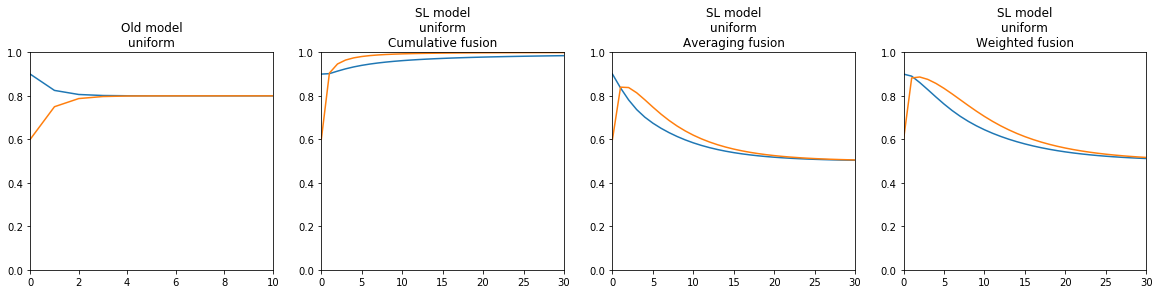

In [15]:
AKV_NUM_STEPS = 10
SL_STEPS = 30
NUM_AGENTS = 2

akv_model = AKVModel([0.9, 0.6], [[1, 1], [0.5, 1]])
sl_model_cumulative = akv_to_sl(akv_model)
sl_model_average = akv_to_sl(akv_model)
sl_model_weighted = akv_to_sl(akv_model)

akv_model.simulate(AKV_NUM_STEPS)
sl_model_cumulative.simulate(SL_STEPS, cumulative_fusion)
sl_model_average.simulate(SL_STEPS, averaging_fusion)
sl_model_weighted.simulate(SL_STEPS, weighted_fusion)

fig, ax = plt.subplots(1, 4)
fig.set(figwidth=20)
for i in range(NUM_AGENTS):
    print()
    ax[0].plot(list(range(AKV_NUM_STEPS + 1)), [akv_model.states[j][i] for j in range(AKV_NUM_STEPS + 1)])
    ax[1].plot(list(range(SL_STEPS + 1)), [sl_model_cumulative.states[j][i].P[0] for j in range(SL_STEPS + 1)])
    ax[2].plot(list(range(SL_STEPS + 1)), [sl_model_average.states[j][i].P[0] for j in range(SL_STEPS + 1)])
    ax[3].plot(list(range(SL_STEPS + 1)), [sl_model_weighted.states[j][i].P[0] for j in range(SL_STEPS + 1)])

ax[0].set_title("Old model\nuniform")
ax[1].set_title("SL model\nuniform\nCumulative fusion")
ax[2].set_title("SL model\nuniform\nAveraging fusion")
ax[3].set_title("SL model\nuniform\nWeighted fusion")
for i in range(4):
    ax[i].set_ylim([0, 1])
    ax[i].set_xlim([0, AKV_NUM_STEPS if i == 0 else SL_STEPS])

In [16]:
sl_model_weighted.states

[[Hyperopinion(2, [0.8 0. ], [0.5 0.5]),
  Hyperopinion(2, [0.2 0. ], [0.5 0.5])],
 [Hyperopinion(2, [0.781081 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.764706 0.      ], [0.5 0.5])],
 [Hyperopinion(2, [0.722128 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.773275 0.      ], [0.5 0.5])],
 [Hyperopinion(2, [0.656637 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.751156 0.      ], [0.5 0.5])],
 [Hyperopinion(2, [0.589389 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.714499 0.      ], [0.5 0.5])],
 [Hyperopinion(2, [0.524591 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.668897 0.      ], [0.5 0.5])],
 [Hyperopinion(2, [0.465095 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.61792 0.     ], [0.5 0.5])],
 [Hyperopinion(2, [0.412074 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.564485 0.      ], [0.5 0.5])],
 [Hyperopinion(2, [0.365412 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.510993 0.      ], [0.5 0.5])],
 [Hyperopinion(2, [0.324367 0.      ], [0.5 0.5]),
  Hyperopinion(2, [0.459272 0.      ], [0.5 